next:

kfold (leave one out?)
look into whitekernel
mess with p value threshold
calculate dlb and ctrl

In [46]:
import distanceCorrelation as dc
import numpy as np
import math
import pandas as pd
import random
import sklearn.gaussian_process as gp
import heapq
import copy
import scipy.stats as sp
import sys
import subprocess
import inspect
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import warnings
import datetime
import networkx as nx
import csv
import os
import matplotlib.pyplot as plt


#https://www.geeksforgeeks.org/using-jupyter-notebook-in-virtual-environment/

In [2]:
df = pd.read_excel("Obeid_set_control_visit1.xlsx")
#df.drop(df[df.Group!="Ctrl"].index, inplace=True)
df.drop("PFI", axis=1, inplace=True)
df = df.apply(sp.zscore)
print(df)

     HexSph(d18:1)  HexCer(d18:1/14:0)  HexCer(d18:1/16:0)  \
0         2.638076           -0.769062           -0.768450   
1        -0.061101           -1.386076           -1.252752   
2        -0.927758            0.390876            0.689601   
3        -0.562430            1.030497            1.042936   
4        -0.841340            1.368181            0.490445   
..             ...                 ...                 ...   
113      -0.230057           -1.059481           -1.514699   
114      -0.112734            0.990947            0.837592   
115      -1.390655           -1.178335           -1.099692   
116      -0.045407           -1.558056           -1.846219   
117      -0.476131           -0.170501           -0.553878   

     HexCer(d18:1/18:1)  HexCer(d18:1/18:0)  HexCer(d18:1/20:1)  \
0             -0.732716            0.350550           -0.664229   
1             -1.243343           -1.232974           -0.669430   
2              0.199303            0.670264           

In [20]:
def outputPredictions(arr):
    if len(arr[0])==1:
        molecule=arr[1][0]
    else:
        molecule=arr[0][0]
    
    with open("output_predictions/"+molecule.replace('/','|')+".csv", 'w', newline = '') as file:
        writer = csv.writer(file)

        for row in arr:
            if len(row)==1:
                writer.writerow("1")
            else:
                writer.writerow([row[0]]+[row[1]]+list(row[2])+list(row[3]))
                

In [21]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

kernel1 = gp.kernels.DotProduct()
kernel2 = gp.kernels.RBF() + gp.kernels.WhiteKernel()
kernel= kernel1+kernel2

#models=[]
loss=[] #to be 2D array for all loss values
count=0.0

for molecule1 in df:
    count+=1
    print(str(round(count*100/len(df.columns),2)) + "% complete")
    #molecule1models=[]
    molecule1Loss=[] #1D array, loss values for single molecule
    for molecule2 in df:
        if molecule1==molecule2: #ensure we don't compare a molecule to itself
            molecule1Loss+=[[molecule1]]
            #molecule1models+=NULL

        else:
            #Splitting into train and validation sets

            sources = df[molecule1].values

            targets = df[molecule2].values

            predictions = []
            predtargets = []

            for j in range(4):

                i = random.randint(0,len(sources)-1)
                x = np.delete(sources, i)
                y = np.delete(targets, i)

                cvx = np.array(sources[i])
                #cvy = np.array(targets[:i+1])

                x = x.reshape(-1,1)
                cvx = cvx.reshape(1,-1)

                model = gp.GaussianProcessRegressor(kernel=kernel).fit(x,y)
                #molecule1Loss+=[model.score(cvx,cvy)] #for outputting score

                #for outputting pvalue
                predictions+=[model.predict(cvx)]
                predtargets+=[targets[i]]
                pass

            #predictions = np.array(predictions).flatten()
            #_,pval=sp.ttest_rel(predictions,targets)
            
            molecule1Loss += [[molecule1, molecule2,np.array(predictions).flatten(), predtargets]]
            
    outputPredictions(molecule1Loss)
    pass

2.33% complete
4.65% complete
6.98% complete
9.3% complete
11.63% complete
13.95% complete
16.28% complete
18.6% complete
20.93% complete
23.26% complete
25.58% complete
27.91% complete
30.23% complete
32.56% complete
34.88% complete
37.21% complete
39.53% complete
41.86% complete
44.19% complete
46.51% complete
48.84% complete
51.16% complete
53.49% complete
55.81% complete
58.14% complete
60.47% complete
62.79% complete
65.12% complete
67.44% complete
69.77% complete
72.09% complete
74.42% complete
76.74% complete
79.07% complete
81.4% complete
83.72% complete
86.05% complete
88.37% complete
90.7% complete
93.02% complete
95.35% complete
97.67% complete
100.0% complete


In [44]:
""" #output predictions to files

for arr in loss:
    if arr[0][0]==1.0:
        molecule=arr[1][0]
    else:
        molecule=arr[0][0]
    
    with open("output_predictions/"+molecule+".csv", 'w', newline = '') as file:
        writer = csv.writer(file)

        for row in arr:
            if row[0]!=1.0:
                writer.writerow([row[0]]+[row[1]]+list(row[2])+list(row[3]))
            else:
                writer.writerow("1")

        pass
 """

NameError: name 'loss' is not defined

In [22]:
#read predictions from files

i=-1
predictions = []
for filename in os.listdir("output_predictions"):
    if filename.endswith(".csv"):

        file_path = os.path.join('output_predictions', filename)

        with open(file_path, "r") as csv_file:
            
            csv_reader = csv.reader(csv_file)
            predictions+=[[]]
            i+=1

            for row in csv_reader:
                predictions[i]+=[row]

In [25]:
#calculate mse values from predictions

errors = {}

for molecule in predictions:
    moleculeErrors = []
    for row in molecule:
        if len(row)==1:
            moleculeErrors += [0.0]
        else:
            preds = row[2:6]
            targets= row[6:]

            squared_errors = [(float(preds[i]) - float(targets[i])) ** 2 for i in range(len(preds))]
            moleculeErrors += [sum(squared_errors) / len(targets)]

    if len(molecule[0])==1:
        errors[molecule[1][0]] = moleculeErrors
    else:
        errors[molecule[0][0]] = moleculeErrors

pass

In [26]:
#output mse to csv

with open("output_mse/output.csv", 'w', newline = '') as file:
    writer = csv.writer(file)

    writer.writerow(df.columns)
    for molecule in df:
        writer.writerow(errors[molecule])

In [80]:
#read in prior knowledge adjacency matrix

priors = []

with open("Adjacency_matrix_Obeid_March17_2023_version_3d.csv", 'r') as file:
    csv_reader = csv.reader(file)

    for row in csv_reader:
        priors+= [row[1:]]

    columns = priors[0]
    priors = priors[1:]    
    pass

In [82]:
#adjust for directionality

for i in range(len(priors)):
    for j in range(len(priors)):
        if errors[columns[i]][j]>0.0 and priors[i][j]=='1':
            if errors[columns[i]][j]>errors[columns[j]][i]:
                priors[i][j]="0"
            else:
                priors[j][i]="0"


In [83]:
#get mse from each prior, calculate threshold
sig_error=[]
all_error=[]

for i in range(len(priors)):
    for j in range(len(priors)):
        if errors[columns[i]][j]>0.0:
            all_error+=[errors[columns[i]][j]]
        if priors[i][j]=='1':
            sig_error+=[errors[columns[i]][j]]

threshold = np.mean(sig_error)
mean = np.mean(all_error)


sig_error.sort()
all_error.sort()

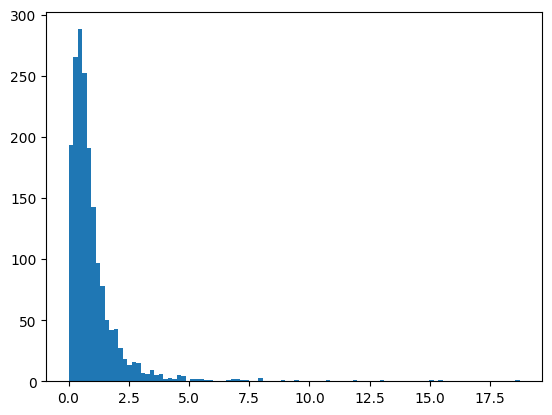

In [62]:
#distribution of all mse
plt.hist(all_error,100)
plt.show()

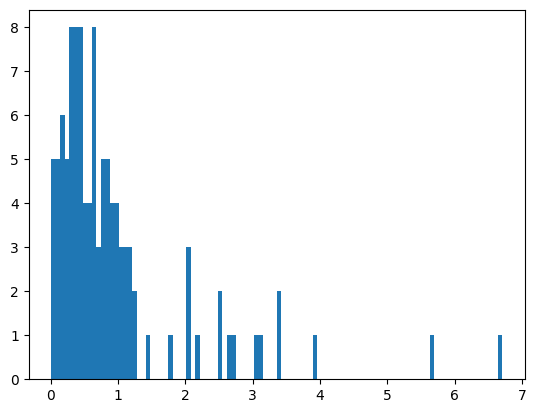

0.6352030343379731
0.6751507251771326


In [64]:
#distribution of mse from prior known pairs
plt.hist(sig_error,100)
plt.show()
print(np.median(sig_error))
print(np.median(all_error))

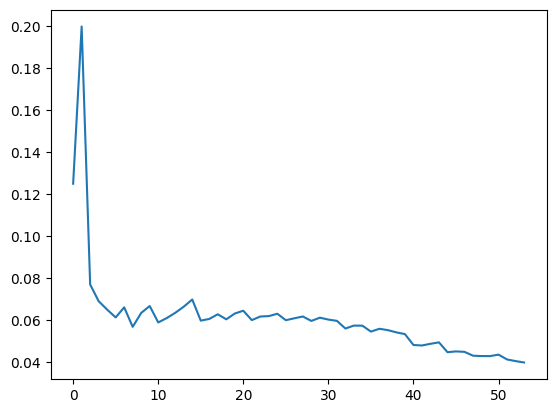

In [84]:
#ratio between prior known pairs and total pairs included below given threshold

count = []

for i in range(len(sig_error[1:])):
    count+=[(len([e for e in all_error if e<sig_error[i+1]]))/(i+1)]

plt.plot(count)
plt.show()

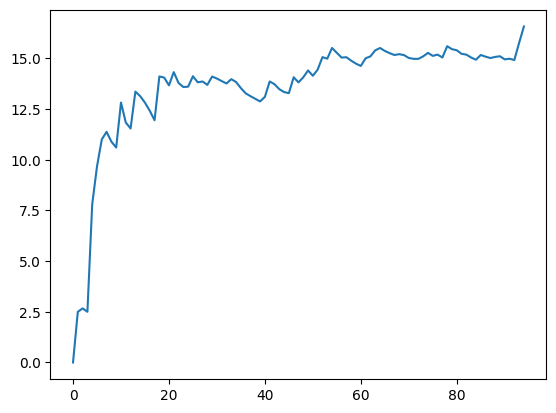

In [75]:
#

sig_error_p=[e for e in sig_error if e<2.0]
all_error_p=[e for e in all_error if e<4.0]

count = []

for i in range(len(sig_error_p)):
    count+=[(len([e for e in all_error_p if e<sig_error_p[i]]))/(i+1)]

plt.plot(count)
plt.show()

In [37]:
#map threshold, output binary matrix


with open("output_bmat/output.csv", 'w', newline = '') as file:
    writer = csv.writer(file)

    writer.writerow(df.columns)
    for molecule in df:
        out_arr = [1 if e<threshold else 0 for e in errors[molecule]]
        writer.writerow(out_arr)

In [ ]:
with open("output_mse/output.csv",'r'):
    csv_reader = csv.reader(csv_file)

    for row in csv_reader:
        